# Gaussian Process Latent Variable Model

Open processed video sample using OpenCV library:

In [1]:
import numpy as np
import cv2

w,h = 120,90

sample = np.load('data\samplevideo.npy')
print(sample[0,:])

[ 116.  121.  130. ...,  109.   67.   65.]


Function for displaying one frame:

In [2]:
def show_frame(frame):
    
    mp.imshow(frame.reshape((h,w)),cmap='Greys_r')

Plot the first frame of sample:

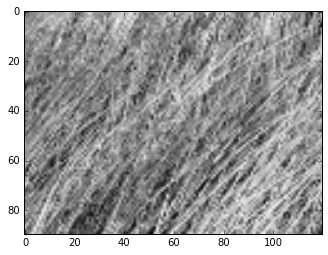

In [3]:
import matplotlib.pyplot as mp

% matplotlib inline
show_frame(sample[0,:])

Initialize all the parameters and normilize given sample:

In [4]:
N = sample.shape[0] # count of samples
D = sample.shape[1] # dimensionality of observed space
Q = 20 # dimensionality of observed space

X = np.zeros((N,Q)) # Initialize the latent variable

#normilizing data:
sample_mean = np.mean(sample, 0)
sample_std = np.std(sample, 0)
sample = (sample - sample_mean)/sample_std # normalization

print(sample)

[[-1.11651213 -1.01944808 -0.23999337 ..., -0.12147499 -1.15733176
  -1.52699203]
 [-0.28189271 -0.92650059 -0.3284865  ...,  0.78656064 -0.78029405
   1.12758945]
 [ 0.39623557 -0.8335531  -0.01876054 ...,  1.19013202  0.17680168
   3.23846147]
 ..., 
 [-2.1597864   0.14239556 -0.85944528 ...,  0.3493583  -0.72228825
   1.03164073]
 [ 1.49167355 -0.36881564 -1.25766437 ...,  0.08031071  0.98888291
   0.10413635]
 [-0.54271128  1.86192413 -0.90369185 ...,  1.02197728  0.5538394
  -0.27965856]]


Define combined kernel using GPy library:

In [5]:
import GPy

#kernel = GPy.kern.Linear(Q,ARD=True)+GPy.kern.RBF(Q,ARD=True)+GPy.kern.RatQuad(Q,ARD=True)+GPy.kern.MLP(Q,ARD=True)+GPy.kern.Matern52(Q,ARD=True)
kernel = GPy.kern.RBF(Q,ARD=True)
m = GPy.models.GPLVM(sample, input_dim=Q, kernel=kernel, init='PCA')

Optimization of the model using SCG (Warning! Minimum value for max_iters is 100, for 10000 it takes around 1 hour to perform optimization)

In [6]:
m.optimize(messages=True, optimizer = 'SCG',max_iters=100)

Extract latent X from the model:

In [7]:
X = m.X
print(X)

  index      |  GPLVM.latent_mean  |  constraints  |  priors
  [0 0]      |        -1.48646453  |               |        
  [0 1]      |         1.75792279  |               |        
  [0 2]      |        -1.13465674  |               |        
  [0 3]      |        -0.59510289  |               |        
  [0 4]      |         0.56045732  |               |        
  [0 5]      |        -2.68316327  |               |        
  [0 6]      |         0.99676886  |               |        
  [0 7]      |        -0.66763348  |               |        
  [0 8]      |         0.93377656  |               |        
  [0 9]      |        -1.30517560  |               |        
  [ 0 10]    |         0.10749320  |               |        
  [ 0 11]    |         0.43685144  |               |        
  [ 0 12]    |        -0.30676967  |               |        
  [ 0 13]    |         1.27289350  |               |        
  [ 0 14]    |        -0.82106663  |               |        
  [ 0 15]    |         0

In [8]:
# Save data to tmp file
np.save('test_X', X)

Plot first 5 values to visualize:

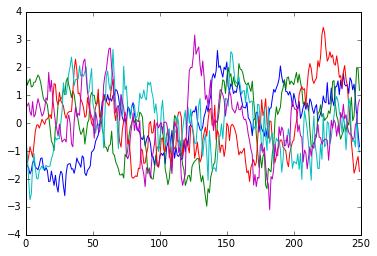

In [9]:
mp.plot(X[:,0:5])

Extract kernel matrix:

In [10]:
Kx = kernel.K(X[0:N-1])
print(Kx)

[[ 0.61477635  0.48591373  0.32142154 ...,  0.02640186  0.07642159
   0.06582912]
 [ 0.48591373  0.61477635  0.48743119 ...,  0.02791645  0.06230177
   0.05313189]
 [ 0.32142154  0.48743119  0.61477635 ...,  0.02358989  0.05370646
   0.0563983 ]
 ..., 
 [ 0.02640186  0.02791645  0.02358989 ...,  0.61477635  0.282176
   0.10058171]
 [ 0.07642159  0.06230177  0.05370646 ...,  0.282176    0.61477635
   0.32662991]
 [ 0.06582912  0.05313189  0.0563983  ...,  0.10058171  0.32662991
   0.61477635]]


Function to predict new artificial frame using mean prediction method:

In [11]:
def predict_new_frame(N,X,kern,Kx_inv,X_old):
    
    k_x = kern.K(X[0:N-1],X_old)
    #k_xx = kern.K(X_old,X_old)

    meann = np.matmul(np.matmul(np.transpose(X[1:N]),Kx_inv),k_x).flatten()
    #cov = (k_xx - np.matmul(np.matmul(np.transpose(k_x),Kx_inv),k_x)) * np.eye(Q)
    
    #R = np.random.multivariate_normal(meann,cov)
    R = meann
    
    return R

Perform prediciton of new X:

In [12]:
N_synt = N  #for evaluation - the same number as in the input
X_synt = np.zeros((N_synt,Q))
X_last = X[N-1:N]
Kx_inv = np.linalg.inv(Kx)

for i in range(N_synt):
    X_synt[i,:] = predict_new_frame(N,X,kernel,Kx_inv,X_last.reshape(1,Q))
    X_last = X_synt[i,:]
    
print(X_synt)

[[-0.70752287  0.63704604 -1.22309664 ...,  0.30880484 -0.63802804
  -0.94267493]
 [-1.0312482   0.82463007 -1.52402845 ...,  0.07506371 -0.30923451
  -1.23657428]
 [-1.2100723   0.80581351 -1.4535695  ..., -0.06879541 -0.09687419
  -1.17055511]
 ..., 
 [ 0.86200516  1.61367226 -0.20413661 ...,  0.27465603 -1.49637483
   0.28445932]
 [ 0.59876952  1.81861476  0.06799961 ...,  0.23634666 -0.14772345
   0.10764332]
 [ 0.51433568  1.44992635  0.46016609 ...,  0.24719338  1.11116434
  -0.25641569]]


Plot of new X:

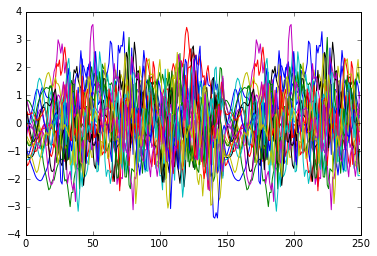

In [13]:
mp.plot(X_synt)

In [ ]:
# Save data to tmp file
np.save('test_X_synt', X_synt)

Now perform syntesis of the dinamic texture based on new X by using multivariate Gaussian:

In [14]:
Y_synt = np.zeros((N_synt,D))

kernel2 = kernel #GPy.kern.RBF(Q,ARD=True) #try original kernel
Ky = kernel2.K(X)
Ky_inv = np.linalg.inv(Ky)
Y_t = np.transpose(sample)


    
k_y = kernel2.K(X,X_synt)
k_yy = kernel2.K(X_synt,X_synt)
meann = np.matmul(np.matmul(Y_t,Ky_inv),k_y)
cov = (k_yy - np.matmul(np.matmul(np.transpose(k_y),Ky_inv),k_y))


for i in range(D):
    Y_synt[:,i] = np.matmul(cov,np.random.randn(N_synt)) + meann[i,:]

print(Y_synt)

[[-1.01308669  1.34568748  0.23889237 ...,  0.35955093 -0.15331043
  -1.08682065]
 [-1.42678045  1.39604274  0.46634378 ...,  0.51964719  0.0883845
  -1.20069573]
 [-1.39074278  1.12555049  0.81327374 ...,  0.32224481  0.08181175
  -1.20758996]
 ..., 
 [-1.58334964  0.01268288  0.06190742 ..., -1.40322898 -1.36056556
  -0.4720198 ]
 [-0.17747162 -1.34651836  0.51222414 ..., -0.66346368 -1.56733826
  -0.95003056]
 [-2.15796404  0.23003277  0.55564471 ..., -0.05794138  0.02783946
  -0.47445988]]


In [ ]:
# Save data to tmp file
np.save('test_Y_synt', Y_synt)

Display first frame:

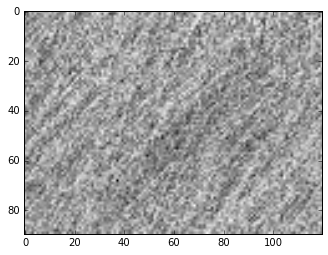

In [15]:
show_frame(Y_synt[1,:])

Finally, save video:

In [45]:
max = Y_synt[:,:].max()
min = Y_synt[:,:].min()
print(min, max)

-5.00626472811 5.78863958851


In [46]:
Y_synt_denorm = (255/(max - min))*(Y_synt - min)
max = Y_synt_denorm[:,:].max()
min = Y_synt_denorm[:,:].min()
print(min, max)

0.0 255.0


In [47]:
cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'DIB ')
#fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('data\out_eval.avi',fourcc, 25.0, (w,h))

for i in range(N_synt):
    print(i)
    frame = Y_synt_denorm[i,:].reshape((h,w)).astype(int)
    max = frame.max()
    min = frame.min()
    frame = (255/(max - min))*(frame - min)    
    img = np.zeros((90,120,3), np.uint8)
    img[:,:,0] = frame
    img[:,:,1] = frame
    img[:,:,2] = frame
    out.write(img)
    print(img)

cap.release()
out.release()
cv2.destroyAllWindows()
print('Done!')

0
[[[ 88  88  88]
  [171 171 171]
  [131 131 131]
  ..., 
  [105 105 105]
  [108 108 108]
  [105 105 105]]

 [[133 133 133]
  [ 68  68  68]
  [157 157 157]
  ..., 
  [120 120 120]
  [ 97  97  97]
  [151 151 151]]

 [[121 121 121]
  [ 81  81  81]
  [108 108 108]
  ..., 
  [126 126 126]
  [ 53  53  53]
  [158 158 158]]

 ..., 
 [[174 174 174]
  [ 93  93  93]
  [134 134 134]
  ..., 
  [126 126 126]
  [163 163 163]
  [112 112 112]]

 [[137 137 137]
  [109 109 109]
  [163 163 163]
  ..., 
  [120 120 120]
  [161 161 161]
  [ 91  91  91]]

 [[ 85  85  85]
  [148 148 148]
  [121 121 121]
  ..., 
  [136 136 136]
  [118 118 118]
  [ 85  85  85]]]
1
[[[ 89  89  89]
  [178 178 178]
  [149 149 149]
  ..., 
  [ 91  91  91]
  [120 120 120]
  [120 120 120]]

 [[140 140 140]
  [ 70  70  70]
  [161 161 161]
  ..., 
  [126 126 126]
  [105 105 105]
  [161 161 161]]

 [[140 140 140]
  [ 87  87  87]
  [132 132 132]
  ..., 
  [153 153 153]
  [ 52  52  52]
  [178 178 178]]

 ..., 
 [[174 174 174]
  [109 109 1